<span style="font-size: 14pt">MIPT, Information Retrieval, Autumn 2017</span>

<span style="font-size: 16pt"> Seminar #9: Intro into Ranking</span>

<img width=300 src="./priestor34.jpg">

based on https://github.com/fabianp/minirank/blob/master/notebooks/pairwise_transform.ipynb

<span style="color:blue; font-size: 12pt">Anstasiya Zukhba</span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">a__l@mail.ru</span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko</span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>


**Key words:** 
   TODO: 


<h3> Plan </h3>
  * **HW5 discussion** (10 minutes)
     
  * ** Ranking Problem Statement ** (20 minutes)
  
  * ** The pairwise transform ** (20 minutes)
     - Dataset
     - Theory of pairwise transform 
     - The pairwise transform with scikit-learn
     
  * **RankLib (The Lemur Project)** (30 minutes)</span> 

<h1 align="center"> Ranking Problem Statement </h1>
TODO: add theory about ranking

<h1 align="center"> The pairwise transform </h1>

In [3]:
import itertools
import numpy as np
from scipy import stats, linalg
from sklearn import svm, linear_model, model_selection

import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('text', usetex=True)
plt.rc('text.latex', unicode=True)
plt.rc('text.latex', preamble='\\usepackage[utf8]{inputenc}')
plt.rc('text.latex', preamble='\\usepackage[russian]{babel}')
plt.rc('font', family='serif', size='16')

# Dataset
Сгенерируем датасет из 60 объектов с двумя признаками, для которого оценка релевантности принимает три различных значения --- 0, 1 и 2.
Датасет имеет два различных запроса, по каждому из которых есть 30 потенциально релеватных документа.
На графике точки, соответствующие парам запрос-документ для первого запроса изображены круглыми точкам, для второго --- треугольными.

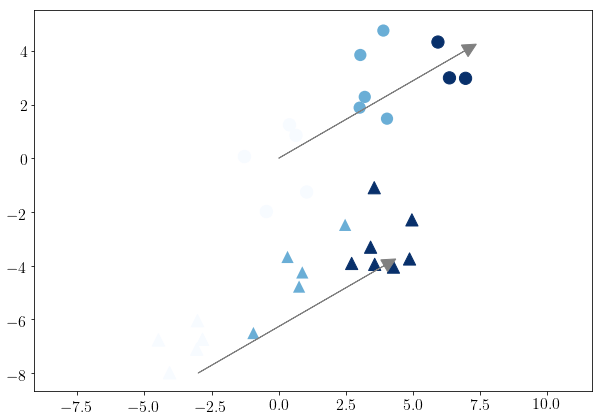

In [10]:
np.random.seed(21)
theta = np.deg2rad(60)
w = np.array([np.sin(theta), np.cos(theta)])
K = 20
X = np.random.randn(K, 2)
y = [0] * K
for i in range(1, 3):
    X = np.concatenate((X, np.random.randn(K, 2) + i * 4 * w))
    y = np.concatenate((y, [i] * K))

# slightly displace data corresponding to our second partition
X[::2] -= np.array([3, 7]) 
blocks = np.array([0, 1] * int(X.shape[0] / 2))

# split into train and test set
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)
for train_index, test_index in cv.split(X, y):
    X_train, y_train, b_train = X[train_index], y[train_index], blocks[train_index]
    X_test, y_test, b_test = X[test_index], y[test_index], blocks[test_index]

# plot the result
idx = (b_train == 0)
plt.figure(figsize=(10, 7))
plt.scatter(X_train[idx, 0], X_train[idx, 1], c=y_train[idx], marker='^', 
            cmap=plt.cm.Blues, s=150, lw=(1 - y_train[idx]))
plt.scatter(X_train[~idx, 0], X_train[~idx, 1], c=y_train[~idx], marker='o', 
            cmap=plt.cm.Blues, s=150, lw=(1 - y_train[~idx]))
plt.arrow(0, 0, 8 * w[0], 8 * w[1], fc='gray', ec='gray', 
          head_width=0.5, head_length=0.5)
plt.arrow(-3, -8, 8 * w[0], 8 * w[1], fc='gray', ec='gray', 
          head_width=0.5, head_length=0.5)
plt.axis('equal')
plt.show()

На графике четко видно, что для обоих запросов есть общий вектор $w$, такой что проекция на него дает правильное ранжирование.
Однако, линейные модели считают, что все объекты лежат в некотором метрическом пространстве.
Таким образом, при рассмотрении таких моделей мы будем получать результат явно не оптимальный.

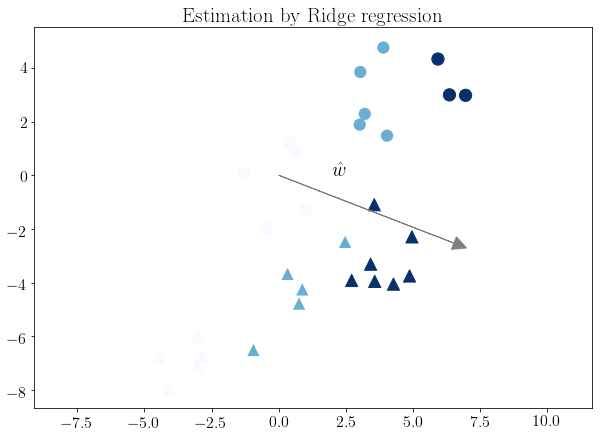

In [11]:
ridge = linear_model.Ridge(1.)
ridge.fit(X_train, y_train)
coef = ridge.coef_ / linalg.norm(ridge.coef_)

plt.figure(figsize=(10, 7))
plt.scatter(X_train[idx, 0], X_train[idx, 1], c=y_train[idx], marker='^', 
            cmap=plt.cm.Blues, s=150, lw=(1 - y_train[idx]))
plt.scatter(X_train[~idx, 0], X_train[~idx, 1], c=y_train[~idx], marker='o', 
            cmap=plt.cm.Blues, s=150, lw=(1 - y_train[~idx]))
plt.arrow(0, 0, 7 * coef[0], 7 * coef[1], fc='gray', ec='gray', 
          head_width=0.5, head_length=0.5)
plt.text(2, 0, '$\hat{w}$', fontsize=20)
plt.axis('equal')
plt.title('Estimation by Ridge regression')
plt.show()

Для оценки качества нашей модели мы должны определить некоторую метрику качества.
Поскольку нас интересует только то, как данная модель сортирует данные, естественно рассматривать метрику, которая сравнивает порядок, порождаемый моделью, с заданным порядком.
Давайте использовать для этого коэффициент корреляции Кенделла (http://en.wikipedia.org/wiki/Kendall_tau_rank_correlation_coefficient), который определяется как
$$\frac{P - Q}{P + Q},$$
где $P$ --- количество пар, для которых взаимный порядок совпадает (для двух заданных ранжирований), $Q$ --- количество пар, для которых он не совпадает.
Эта метрика широко используется в литературе по ранжированию (http://www.cs.cornell.edu/people/tj/publications/joachims_02c.pdf)

Применим эту метрику на тесте для каждого запроса отдельно.

In [13]:
for i in range(2):
    tau, _ = stats.kendalltau(ridge.predict(X_test[b_test == i]), y_test[b_test == i])
    print('Kendall correlation coefficient for query %s: %.3f' % (i, tau))

Kendall correlation coefficient for query 0: 0.779
Kendall correlation coefficient for query 1: 0.801


# Theory of pairwise transform
TODO: add general information about pairwise transform 

The pairwise transform
----------------------

Как показано в (http://www.mendeley.com/research/support-vector-learning-ordinal-regression/), если мы будем рассматривать линейные функции для ранжирования, вместо задачи ранжирования можно рассматривать эквивалентную задачу двуклассовой классификации.
Для этого мы создадим разности всех сравнимых элементов, то есть наши данные будут преобразованы в $(X'_k, Y'_k) = (X_i - X_j, sign(Y_i - Y_j))$ для пар, для которых можно определить порядок.

Следующий график показывает этот преобразованный датасет, цвет точек отражает разницу в метках, и наша задача --- отделить положительные точки от отрицательных. Гиперплоскость $x^T w = 0$ разделяет эти классы.

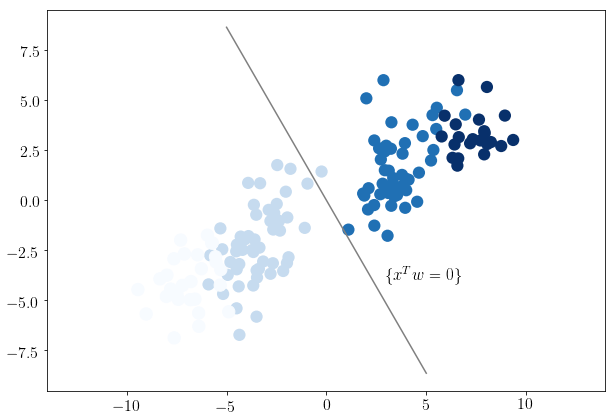

In [17]:
# form all pairwise combinations
comb = itertools.combinations(range(X_train.shape[0]), 2)
k = 0
Xp, yp, diff = [], [], []

for (i, j) in comb:
    if y_train[i] == y_train[j] or b_train[i] != b_train[j]:
        # skip if same target or different group
        continue
        
    Xp.append(X_train[i] - X_train[j])
    diff.append(y_train[i] - y_train[j])
    yp.append(np.sign(diff[-1]))
    k += 1
    
Xp, yp, diff = map(np.asanyarray, (Xp, yp, diff))

plt.figure(figsize=(10, 7))
plt.scatter(Xp[:, 0], Xp[:, 1], c=diff, s=150, lw=(diff == -2), 
            marker='o', cmap=plt.cm.Blues)
x_space = np.linspace(-10, 10)
plt.plot(x_space * w[1], - x_space * w[0], color='gray')
plt.text(3, -4, '$\{x^T w = 0\}$', fontsize=17)
plt.axis('equal')
plt.show()

Как мы видим на предыдущем графике, классы разделимы.
Это не всегда будет так, но на нашей обучающей выборке нет инверсий порядка.

Теперь мы можем обучить SVM на преобразованных данных.
Эта модель называется RankSVM.
Далее приведен график обучающей выборки вместе с оцененным коэффициентом $\hat{w}$ с помощью RankSVM.

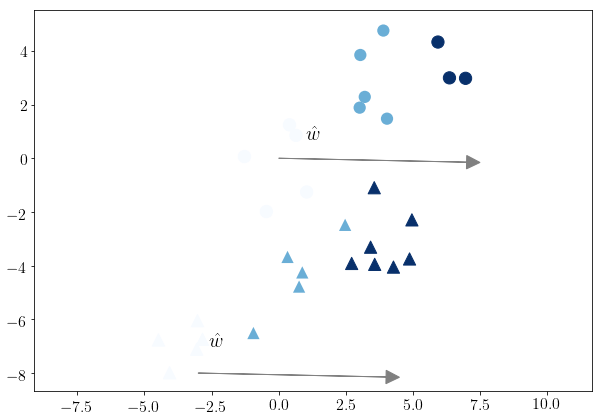

In [18]:
clf = svm.SVC(kernel='linear', C=.1)
clf.fit(Xp, yp)
coef = clf.coef_.ravel() / linalg.norm(clf.coef_)

plt.figure(figsize=(10, 7))
plt.scatter(X_train[idx, 0], X_train[idx, 1], c=y_train[idx], 
            lw=(1 - y_train[idx]), marker='^', cmap=plt.cm.Blues, s=150)
plt.scatter(X_train[~idx, 0], X_train[~idx, 1], c=y_train[~idx], 
            lw=(1 - y_train[~idx]), marker='o', cmap=plt.cm.Blues, s=150)
plt.arrow(0, 0, 7 * coef[0], 7 * coef[1], fc='gray', ec='gray', 
          head_width=0.5, head_length=0.5)
plt.arrow(-3, -8, 7 * coef[0], 7 * coef[1], fc='gray', ec='gray', 
          head_width=0.5, head_length=0.5)
plt.text(1, .7, '$\hat{w}$', fontsize=20)
plt.text(-2.6, -7, '$\hat{w}$', fontsize=20)
plt.axis('equal')
plt.show()

Наконец, убедимся, что коэффициент корреляции Кенделла увеличивается при использовании RankSVM вместо линейной регрессии.

In [19]:
for i in range(2):
    tau, _ = stats.kendalltau(
        np.dot(X_test[b_test == i], coef), y_test[b_test == i])
    print('Kendall correlation coefficient for query %s: %.3f' % (i, tau))

Kendall correlation coefficient for query 0: 0.840
Kendall correlation coefficient for query 1: 0.836


Эти значения действительно больше, чем значения (0.779, 0.801), полученные в случае линейной регрессии.

<h1 align="center"> Conclusion </h1>

TODO: 
** Check questions **

** You can find HW7 here** 
  * оцените <a href="https://goo.gl/forms/SIa0Elv5PrrEnwwa2"> семинар </a>